# Music Genre Classification using Deep Learning

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


# Reading & Understanding Data
## Importing Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

### Loading Dataset

In [41]:
df = pd.read_csv('/Users/navneettesting/Downloads/Mini Project/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### About the dataset

In [42]:
print('Dataset has',df.shape)
print('Count of Positive and Negative samples')
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,reggae,1000
1,blues,1000
2,jazz,1000
3,pop,1000
4,metal,1000
5,disco,999
6,rock,998
7,hiphop,998
8,classical,998
9,country,997


# Data Visualization

In [43]:
audio_fp = '/Users/navneettesting/Downloads/Mini Project/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [44]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

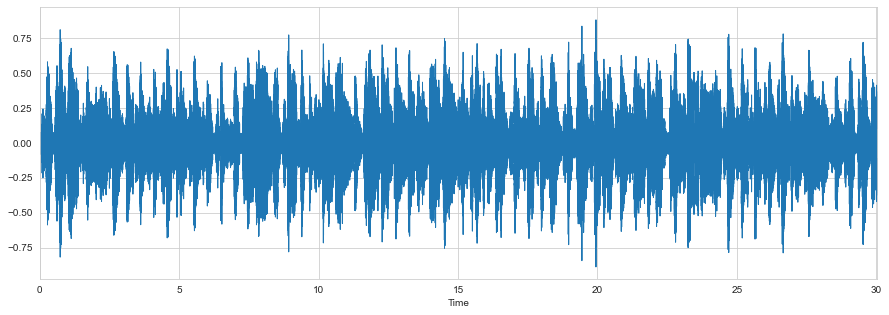

In [45]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

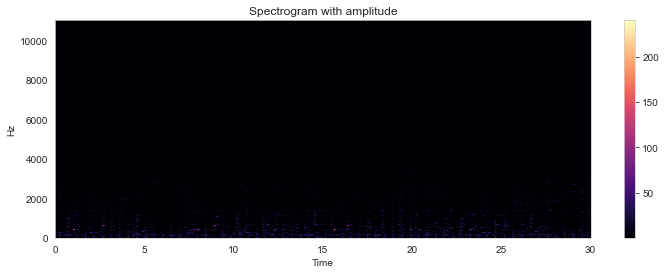

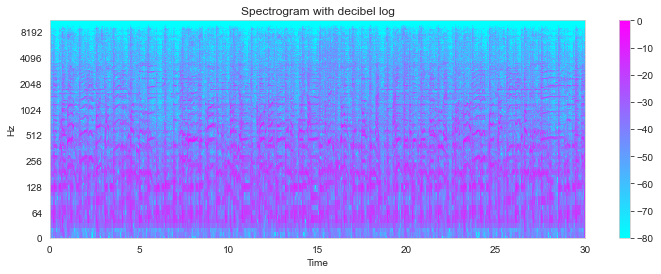

In [46]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spectrogram with amplitude')
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title('Spectrogram with decibel log')
plt.show()

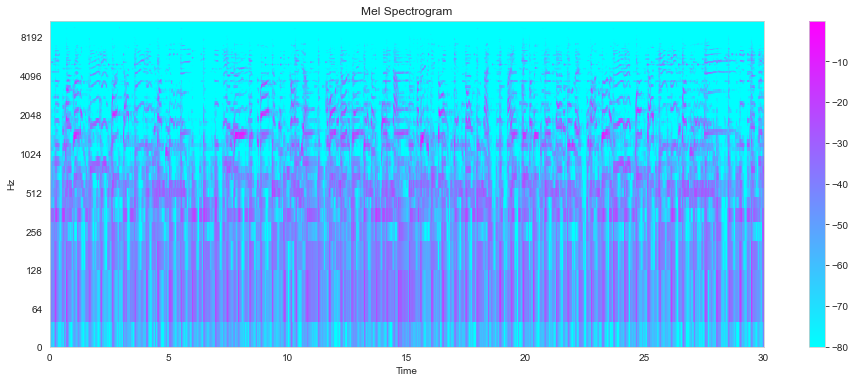

In [47]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title('Mel Spectrogram')
plt.show()

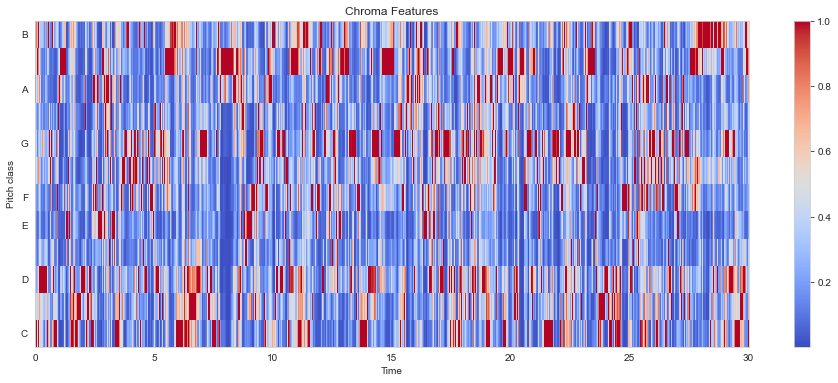

In [48]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma Features')
plt.show()

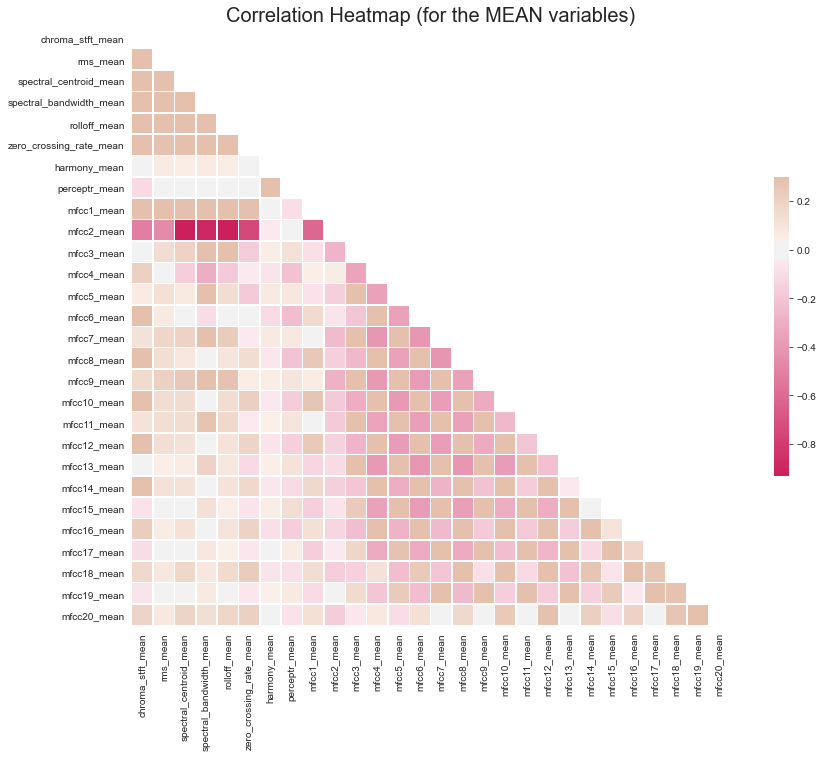

In [49]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig('Corr_Heatmap.png')

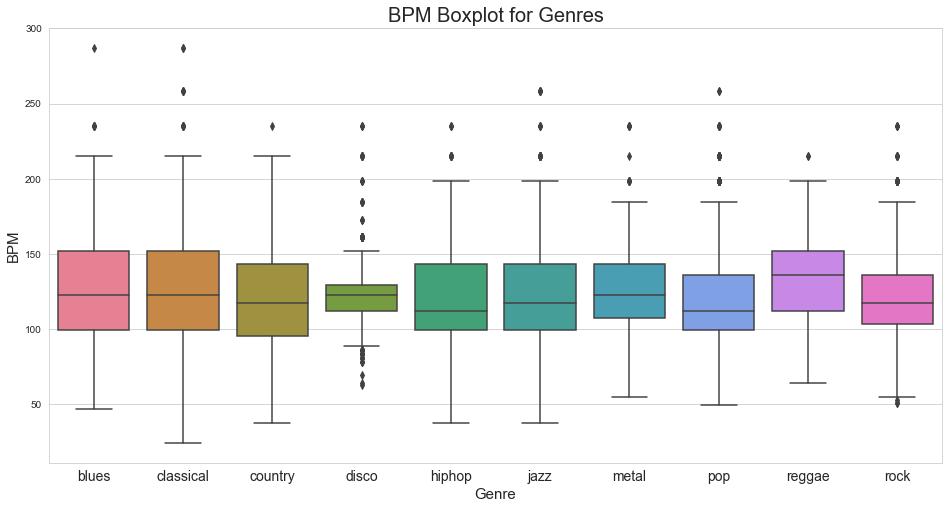

In [50]:
x = df[['label', 'tempo']]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = 'label', y = 'tempo', data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel('Genre', fontsize = 15)
plt.ylabel('BPM', fontsize = 15)
plt.savefig('BPM_Boxplot.png')

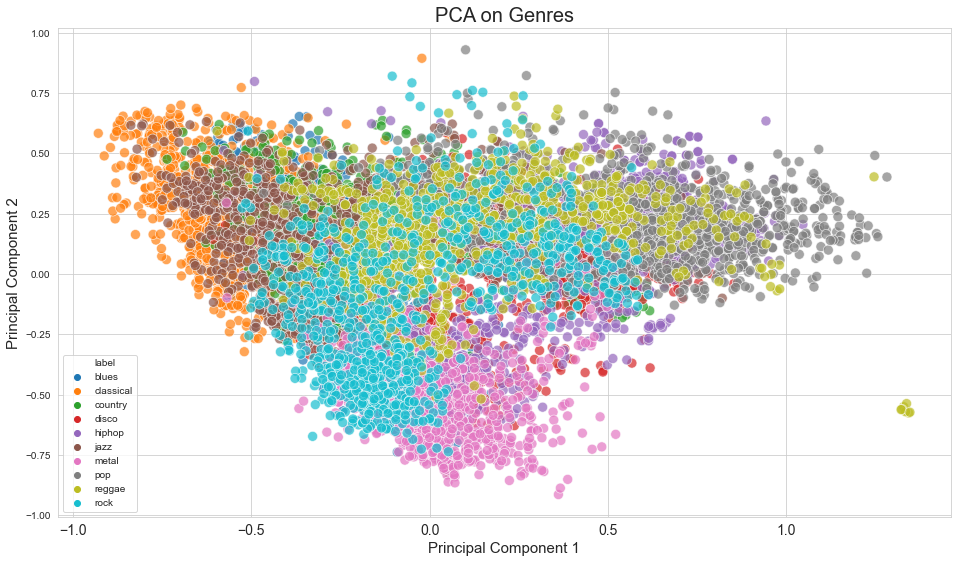

In [51]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = 'pc1', y = 'pc2', data = finalDf, hue = 'label', alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.savefig('PCA_Scattert.png')

# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [52]:
# find all columns with any NA values
print('Columns with NA values are',list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [53]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
    
label_index

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [54]:
index_label

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [55]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train, Dev & Test Sets

In [56]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [57]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size = 0.7,
                                                                           random_state = seed, stratify = df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size = 0.66, 
                                                     random_state = seed, stratify = df_test_valid_y)

In [58]:
print(f'Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%')
print(f'Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%')
print(f'Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%')

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


## Scale the Features

In [59]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Model Building

In [60]:
import tensorflow as tf
print('TF version:-', tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.4.1


In [61]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print('\n\nStopping training as we have reached %2.2f%% accuracy!' %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print('Max. Validation Accuracy',max(history.history['val_accuracy']))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()


In [23]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
55/55 [==============================] - 3s 36ms/step - loss: 1.8209 - accuracy: 0.3679 - val_loss: 1.0579 - val_accuracy: 0.6304
Epoch 2/70
55/55 [==============================] - 0s 7ms/step - loss: 0.9565 - accuracy: 0.6816 - val_

Epoch 53/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.5237 - val_accuracy: 0.8898
Epoch 54/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.5184 - val_accuracy: 0.8943
Epoch 55/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.5288 - val_accuracy: 0.8898
Epoch 56/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.5259 - val_accuracy: 0.8903
Epoch 57/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.5282 - val_accuracy: 0.8948
Epoch 58/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.5293 - val_accuracy: 0.8948
Epoch 59/70
55/55 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.5526 - val_accuracy: 0.8873
Epoch 60/70
5

Max. Validation Accuracy 0.895348846912384


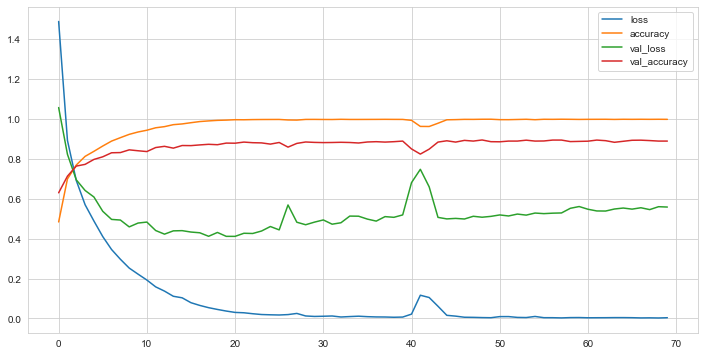

In [24]:
plotHistory(model_1_history)

In [25]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

55/55 [==============================] - 1s 11ms/step - loss: 0.0707 - accuracy: 0.9812 - val_loss: 0.3668 - val_accuracy: 0.9044
Epoch 48/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0617 - accuracy: 0.9829 - val_loss: 0.3783 - val_accuracy: 0.9050
Epoch 49/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0655 - accuracy: 0.9799 - val_loss: 0.3657 - val_accuracy: 0.9161
Epoch 50/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0481 - accuracy: 0.9839 - val_loss: 0.4127 - val_accuracy: 0.9009
Epoch 51/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0811 - accuracy: 0.9768 - val_loss: 0.3887 - val_accuracy: 0.9050
Epoch 52/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0632 - accuracy: 0.9801 - val_loss: 0.3841 - val_accuracy: 0.9151
Epoch 53/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0532 - accuracy: 0.9843 - val_loss: 0.3750 - val_accuracy: 0.9146
Epoch 54/100

Max. Validation Accuracy 0.926188051700592


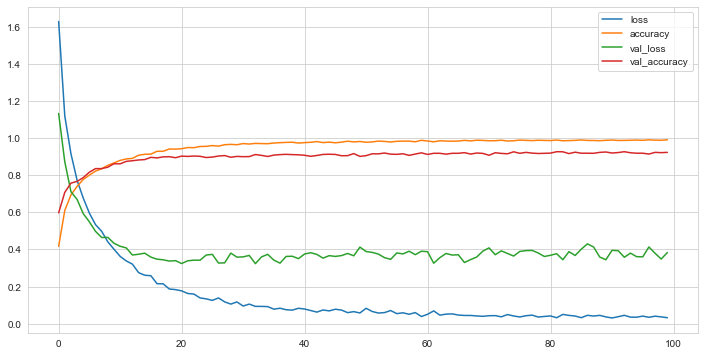

In [26]:
plotHistory(model_2_history)

In [27]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

55/55 [==============================] - 1s 10ms/step - loss: 0.9455 - accuracy: 0.6810 - val_loss: 0.7931 - val_accuracy: 0.7250
Epoch 48/700
55/55 [==============================] - 1s 10ms/step - loss: 0.9162 - accuracy: 0.6884 - val_loss: 0.7876 - val_accuracy: 0.7285
Epoch 49/700
55/55 [==============================] - 1s 10ms/step - loss: 0.8774 - accuracy: 0.6977 - val_loss: 0.7810 - val_accuracy: 0.7305
Epoch 50/700
55/55 [==============================] - 1s 10ms/step - loss: 0.8883 - accuracy: 0.6932 - val_loss: 0.7771 - val_accuracy: 0.7300
Epoch 51/700
55/55 [==============================] - 1s 10ms/step - loss: 0.9118 - accuracy: 0.6953 - val_loss: 0.7691 - val_accuracy: 0.7351
Epoch 52/700
55/55 [==============================] - 1s 10ms/step - loss: 0.8963 - accuracy: 0.6903 - val_loss: 0.7621 - val_accuracy: 0.7341
Epoch 53/700
55/55 [==============================] - 1s 10ms/step - loss: 0.8432 - accuracy: 0.7085 - val_loss: 0.7547 - val_accuracy: 0.7361
Epoch 54/700

55/55 [==============================] - 1s 10ms/step - loss: 0.5667 - accuracy: 0.8103 - val_loss: 0.5461 - val_accuracy: 0.8170
Epoch 105/700
55/55 [==============================] - 1s 11ms/step - loss: 0.5655 - accuracy: 0.8041 - val_loss: 0.5468 - val_accuracy: 0.8170
Epoch 106/700
55/55 [==============================] - 1s 10ms/step - loss: 0.5793 - accuracy: 0.8096 - val_loss: 0.5436 - val_accuracy: 0.8155
Epoch 107/700
55/55 [==============================] - 1s 10ms/step - loss: 0.6128 - accuracy: 0.7936 - val_loss: 0.5401 - val_accuracy: 0.8155
Epoch 108/700
55/55 [==============================] - 1s 10ms/step - loss: 0.5880 - accuracy: 0.8008 - val_loss: 0.5357 - val_accuracy: 0.8195
Epoch 109/700
55/55 [==============================] - 1s 10ms/step - loss: 0.5624 - accuracy: 0.8132 - val_loss: 0.5323 - val_accuracy: 0.8220
Epoch 110/700
55/55 [==============================] - 1s 10ms/step - loss: 0.5493 - accuracy: 0.8155 - val_loss: 0.5300 - val_accuracy: 0.8205
Epoch 

Epoch 161/700
55/55 [==============================] - 1s 13ms/step - loss: 0.4094 - accuracy: 0.8634 - val_loss: 0.4284 - val_accuracy: 0.8605
Epoch 162/700
55/55 [==============================] - 1s 13ms/step - loss: 0.3903 - accuracy: 0.8720 - val_loss: 0.4264 - val_accuracy: 0.8640
Epoch 163/700
55/55 [==============================] - 1s 12ms/step - loss: 0.3720 - accuracy: 0.8815 - val_loss: 0.4268 - val_accuracy: 0.8640
Epoch 164/700
55/55 [==============================] - 1s 12ms/step - loss: 0.4024 - accuracy: 0.8649 - val_loss: 0.4215 - val_accuracy: 0.8615
Epoch 165/700
55/55 [==============================] - 1s 13ms/step - loss: 0.3810 - accuracy: 0.8695 - val_loss: 0.4200 - val_accuracy: 0.8655
Epoch 166/700
55/55 [==============================] - 1s 13ms/step - loss: 0.3899 - accuracy: 0.8703 - val_loss: 0.4200 - val_accuracy: 0.8620
Epoch 167/700
55/55 [==============================] - 1s 12ms/step - loss: 0.3640 - accuracy: 0.8808 - val_loss: 0.4158 - val_accuracy:

Epoch 218/700
55/55 [==============================] - 1s 13ms/step - loss: 0.2625 - accuracy: 0.9128 - val_loss: 0.3626 - val_accuracy: 0.8842
Epoch 219/700
55/55 [==============================] - 1s 13ms/step - loss: 0.2873 - accuracy: 0.9032 - val_loss: 0.3606 - val_accuracy: 0.8822
Epoch 220/700
55/55 [==============================] - 1s 14ms/step - loss: 0.2650 - accuracy: 0.9135 - val_loss: 0.3571 - val_accuracy: 0.8873
Epoch 221/700
55/55 [==============================] - 1s 13ms/step - loss: 0.2562 - accuracy: 0.9152 - val_loss: 0.3558 - val_accuracy: 0.8862
Epoch 222/700
55/55 [==============================] - 1s 13ms/step - loss: 0.2896 - accuracy: 0.9061 - val_loss: 0.3585 - val_accuracy: 0.8847
Epoch 223/700
55/55 [==============================] - 1s 14ms/step - loss: 0.2646 - accuracy: 0.9129 - val_loss: 0.3555 - val_accuracy: 0.8862
Epoch 224/700
55/55 [==============================] - 1s 14ms/step - loss: 0.2780 - accuracy: 0.9014 - val_loss: 0.3537 - val_accuracy:

55/55 [==============================] - 1s 13ms/step - loss: 0.2134 - accuracy: 0.9324 - val_loss: 0.3274 - val_accuracy: 0.8979
Epoch 275/700
55/55 [==============================] - 1s 13ms/step - loss: 0.2065 - accuracy: 0.9345 - val_loss: 0.3246 - val_accuracy: 0.8979
Epoch 276/700
55/55 [==============================] - 1s 14ms/step - loss: 0.1979 - accuracy: 0.9364 - val_loss: 0.3241 - val_accuracy: 0.8953
Epoch 277/700
55/55 [==============================] - 1s 14ms/step - loss: 0.1987 - accuracy: 0.9360 - val_loss: 0.3248 - val_accuracy: 0.8969
Epoch 278/700
55/55 [==============================] - 1s 14ms/step - loss: 0.2017 - accuracy: 0.9336 - val_loss: 0.3275 - val_accuracy: 0.8974
Epoch 279/700
55/55 [==============================] - 1s 11ms/step - loss: 0.1973 - accuracy: 0.9359 - val_loss: 0.3186 - val_accuracy: 0.8984
Epoch 280/700
55/55 [==============================] - 1s 12ms/step - loss: 0.1856 - accuracy: 0.9386 - val_loss: 0.3199 - val_accuracy: 0.8979
Epoch 

55/55 [==============================] - 0s 9ms/step - loss: 0.1549 - accuracy: 0.9492 - val_loss: 0.3202 - val_accuracy: 0.9044
Epoch 332/700
55/55 [==============================] - 1s 10ms/step - loss: 0.1343 - accuracy: 0.9559 - val_loss: 0.3128 - val_accuracy: 0.9055
Epoch 333/700
55/55 [==============================] - 1s 11ms/step - loss: 0.1449 - accuracy: 0.9551 - val_loss: 0.3114 - val_accuracy: 0.9080
Epoch 334/700
55/55 [==============================] - 1s 12ms/step - loss: 0.1421 - accuracy: 0.9566 - val_loss: 0.3156 - val_accuracy: 0.9039
Epoch 335/700
55/55 [==============================] - 1s 12ms/step - loss: 0.1573 - accuracy: 0.9448 - val_loss: 0.3206 - val_accuracy: 0.9019
Epoch 336/700
55/55 [==============================] - 1s 12ms/step - loss: 0.1346 - accuracy: 0.9584 - val_loss: 0.3199 - val_accuracy: 0.9014
Epoch 337/700
55/55 [==============================] - 1s 11ms/step - loss: 0.1379 - accuracy: 0.9556 - val_loss: 0.3179 - val_accuracy: 0.9039
Epoch 3

55/55 [==============================] - 1s 10ms/step - loss: 0.1178 - accuracy: 0.9600 - val_loss: 0.3184 - val_accuracy: 0.9065
Epoch 389/700
55/55 [==============================] - 1s 9ms/step - loss: 0.1150 - accuracy: 0.9633 - val_loss: 0.3088 - val_accuracy: 0.9090
Epoch 390/700
55/55 [==============================] - 0s 9ms/step - loss: 0.1158 - accuracy: 0.9632 - val_loss: 0.3108 - val_accuracy: 0.9075
Epoch 391/700
55/55 [==============================] - 0s 9ms/step - loss: 0.1090 - accuracy: 0.9652 - val_loss: 0.3108 - val_accuracy: 0.9080
Epoch 392/700
55/55 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.9696 - val_loss: 0.3096 - val_accuracy: 0.9070
Epoch 393/700
55/55 [==============================] - 1s 10ms/step - loss: 0.1098 - accuracy: 0.9627 - val_loss: 0.3127 - val_accuracy: 0.9070
Epoch 394/700
55/55 [==============================] - 1s 11ms/step - loss: 0.1088 - accuracy: 0.9650 - val_loss: 0.3126 - val_accuracy: 0.9060
Epoch 395/

55/55 [==============================] - 1s 12ms/step - loss: 0.0927 - accuracy: 0.9694 - val_loss: 0.3106 - val_accuracy: 0.9095
Epoch 446/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0967 - accuracy: 0.9693 - val_loss: 0.3103 - val_accuracy: 0.9090
Epoch 447/700
55/55 [==============================] - 1s 12ms/step - loss: 0.0883 - accuracy: 0.9745 - val_loss: 0.3112 - val_accuracy: 0.9085
Epoch 448/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0825 - accuracy: 0.9735 - val_loss: 0.3117 - val_accuracy: 0.9080
Epoch 449/700
55/55 [==============================] - 1s 10ms/step - loss: 0.0860 - accuracy: 0.9713 - val_loss: 0.3122 - val_accuracy: 0.9070
Epoch 450/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0861 - accuracy: 0.9719 - val_loss: 0.3100 - val_accuracy: 0.9125
Epoch 451/700
55/55 [==============================] - 1s 10ms/step - loss: 0.0913 - accuracy: 0.9714 - val_loss: 0.3128 - val_accuracy: 0.9110
Epoch 

55/55 [==============================] - 1s 9ms/step - loss: 0.0700 - accuracy: 0.9775 - val_loss: 0.3215 - val_accuracy: 0.9115
Epoch 503/700
55/55 [==============================] - 1s 9ms/step - loss: 0.0674 - accuracy: 0.9796 - val_loss: 0.3176 - val_accuracy: 0.9085
Epoch 504/700
55/55 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.9779 - val_loss: 0.3225 - val_accuracy: 0.9120
Epoch 505/700
55/55 [==============================] - 1s 9ms/step - loss: 0.0677 - accuracy: 0.9783 - val_loss: 0.3238 - val_accuracy: 0.9090
Epoch 506/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0731 - accuracy: 0.9808 - val_loss: 0.3210 - val_accuracy: 0.9075
Epoch 507/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0638 - accuracy: 0.9803 - val_loss: 0.3210 - val_accuracy: 0.9125
Epoch 508/700
55/55 [==============================] - 0s 9ms/step - loss: 0.0655 - accuracy: 0.9801 - val_loss: 0.3248 - val_accuracy: 0.9125
Epoch 509/7

55/55 [==============================] - 1s 12ms/step - loss: 0.0587 - accuracy: 0.9833 - val_loss: 0.3202 - val_accuracy: 0.9125
Epoch 560/700
55/55 [==============================] - 1s 13ms/step - loss: 0.0555 - accuracy: 0.9823 - val_loss: 0.3145 - val_accuracy: 0.9176
Epoch 561/700
55/55 [==============================] - 1s 12ms/step - loss: 0.0566 - accuracy: 0.9835 - val_loss: 0.3205 - val_accuracy: 0.9135
Epoch 562/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0661 - accuracy: 0.9806 - val_loss: 0.3175 - val_accuracy: 0.9130
Epoch 563/700
55/55 [==============================] - 1s 10ms/step - loss: 0.0624 - accuracy: 0.9798 - val_loss: 0.3218 - val_accuracy: 0.9135
Epoch 564/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0585 - accuracy: 0.9799 - val_loss: 0.3235 - val_accuracy: 0.9115
Epoch 565/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0656 - accuracy: 0.9805 - val_loss: 0.3192 - val_accuracy: 0.9120
Epoch 

55/55 [==============================] - 1s 9ms/step - loss: 0.0536 - accuracy: 0.9853 - val_loss: 0.3298 - val_accuracy: 0.9141
Epoch 617/700
55/55 [==============================] - 1s 10ms/step - loss: 0.0485 - accuracy: 0.9851 - val_loss: 0.3323 - val_accuracy: 0.9141
Epoch 618/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0476 - accuracy: 0.9871 - val_loss: 0.3281 - val_accuracy: 0.9120
Epoch 619/700
55/55 [==============================] - 1s 10ms/step - loss: 0.0497 - accuracy: 0.9832 - val_loss: 0.3320 - val_accuracy: 0.9141
Epoch 620/700
55/55 [==============================] - 1s 9ms/step - loss: 0.0465 - accuracy: 0.9863 - val_loss: 0.3278 - val_accuracy: 0.9156
Epoch 621/700
55/55 [==============================] - 1s 9ms/step - loss: 0.0480 - accuracy: 0.9853 - val_loss: 0.3283 - val_accuracy: 0.9125
Epoch 622/700
55/55 [==============================] - 1s 9ms/step - loss: 0.0424 - accuracy: 0.9873 - val_loss: 0.3288 - val_accuracy: 0.9130
Epoch 623/

55/55 [==============================] - 1s 14ms/step - loss: 0.0434 - accuracy: 0.9864 - val_loss: 0.3372 - val_accuracy: 0.9130
Epoch 674/700
55/55 [==============================] - 1s 13ms/step - loss: 0.0448 - accuracy: 0.9865 - val_loss: 0.3372 - val_accuracy: 0.9151
Epoch 675/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0423 - accuracy: 0.9856 - val_loss: 0.3405 - val_accuracy: 0.9110
Epoch 676/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0419 - accuracy: 0.9873 - val_loss: 0.3370 - val_accuracy: 0.9110
Epoch 677/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0516 - accuracy: 0.9825 - val_loss: 0.3385 - val_accuracy: 0.9130
Epoch 678/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0448 - accuracy: 0.9841 - val_loss: 0.3362 - val_accuracy: 0.9120
Epoch 679/700
55/55 [==============================] - 1s 11ms/step - loss: 0.0474 - accuracy: 0.9843 - val_loss: 0.3348 - val_accuracy: 0.9130
Epoch 

Max. Validation Accuracy 0.9175935387611389


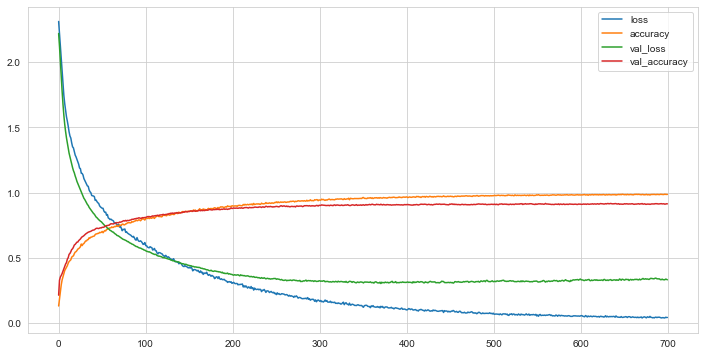

In [28]:
plotHistory(model_3_history)

In [29]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),
    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              59392     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)              

55/55 [==============================] - 2s 36ms/step - loss: 0.1216 - accuracy: 0.9697 - val_loss: 0.3763 - val_accuracy: 0.9211
Epoch 46/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0844 - accuracy: 0.9765 - val_loss: 0.4234 - val_accuracy: 0.9141
Epoch 47/500
55/55 [==============================] - 2s 36ms/step - loss: 0.1056 - accuracy: 0.9673 - val_loss: 0.4741 - val_accuracy: 0.9029
Epoch 48/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0778 - accuracy: 0.9777 - val_loss: 0.4255 - val_accuracy: 0.9181
Epoch 49/500
55/55 [==============================] - 2s 39ms/step - loss: 0.1115 - accuracy: 0.9759 - val_loss: 0.4067 - val_accuracy: 0.9176
Epoch 50/500
55/55 [==============================] - 3s 46ms/step - loss: 0.0963 - accuracy: 0.9723 - val_loss: 0.4608 - val_accuracy: 0.9130
Epoch 51/500
55/55 [==============================] - 2s 38ms/step - loss: 0.0988 - accuracy: 0.9748 - val_loss: 0.4608 - val_accuracy: 0.9191
Epoch 52/500

55/55 [==============================] - 2s 37ms/step - loss: 0.0565 - accuracy: 0.9829 - val_loss: 0.5405 - val_accuracy: 0.9267
Epoch 103/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0616 - accuracy: 0.9880 - val_loss: 0.6102 - val_accuracy: 0.9166
Epoch 104/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0693 - accuracy: 0.9855 - val_loss: 0.5959 - val_accuracy: 0.9257
Epoch 105/500
55/55 [==============================] - 2s 38ms/step - loss: 0.0714 - accuracy: 0.9846 - val_loss: 0.5240 - val_accuracy: 0.9297
Epoch 106/500
55/55 [==============================] - 2s 38ms/step - loss: 0.0577 - accuracy: 0.9876 - val_loss: 0.5624 - val_accuracy: 0.9257
Epoch 107/500
55/55 [==============================] - 2s 38ms/step - loss: 0.0724 - accuracy: 0.9829 - val_loss: 0.4760 - val_accuracy: 0.9343
Epoch 108/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0655 - accuracy: 0.9842 - val_loss: 0.4945 - val_accuracy: 0.9358
Epoch 

Epoch 159/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0499 - accuracy: 0.9906 - val_loss: 0.7009 - val_accuracy: 0.9277
Epoch 160/500
55/55 [==============================] - 2s 36ms/step - loss: 0.1449 - accuracy: 0.9863 - val_loss: 0.6622 - val_accuracy: 0.9272
Epoch 161/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0635 - accuracy: 0.9866 - val_loss: 0.7518 - val_accuracy: 0.9257
Epoch 162/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0584 - accuracy: 0.9884 - val_loss: 0.7034 - val_accuracy: 0.9211
Epoch 163/500
55/55 [==============================] - 2s 35ms/step - loss: 0.0667 - accuracy: 0.9864 - val_loss: 0.6760 - val_accuracy: 0.9252
Epoch 164/500
55/55 [==============================] - 2s 36ms/step - loss: 0.0741 - accuracy: 0.9874 - val_loss: 0.7186 - val_accuracy: 0.9242
Epoch 165/500
55/55 [==============================] - 2s 31ms/step - loss: 0.0727 - accuracy: 0.9855 - val_loss: 0.6230 - val_accuracy:

Epoch 216/500
55/55 [==============================] - 2s 38ms/step - loss: 0.0772 - accuracy: 0.9877 - val_loss: 0.7232 - val_accuracy: 0.9312
Epoch 217/500
55/55 [==============================] - 2s 35ms/step - loss: 0.0505 - accuracy: 0.9913 - val_loss: 0.8909 - val_accuracy: 0.9287
Epoch 218/500
55/55 [==============================] - 2s 32ms/step - loss: 0.0767 - accuracy: 0.9886 - val_loss: 0.7552 - val_accuracy: 0.9333
Epoch 219/500
55/55 [==============================] - 2s 33ms/step - loss: 0.0856 - accuracy: 0.9906 - val_loss: 0.8443 - val_accuracy: 0.9292
Epoch 220/500
55/55 [==============================] - 2s 31ms/step - loss: 0.0633 - accuracy: 0.9885 - val_loss: 0.7808 - val_accuracy: 0.9323
Epoch 221/500
55/55 [==============================] - 2s 34ms/step - loss: 0.0779 - accuracy: 0.9868 - val_loss: 0.9988 - val_accuracy: 0.9317
Epoch 222/500
55/55 [==============================] - 2s 32ms/step - loss: 0.1208 - accuracy: 0.9865 - val_loss: 0.8431 - val_accuracy:

Epoch 273/500
55/55 [==============================] - 2s 31ms/step - loss: 0.0617 - accuracy: 0.9883 - val_loss: 1.0877 - val_accuracy: 0.9302
Epoch 274/500
55/55 [==============================] - 2s 34ms/step - loss: 0.0818 - accuracy: 0.9866 - val_loss: 1.0733 - val_accuracy: 0.9287
Epoch 275/500
55/55 [==============================] - 2s 36ms/step - loss: 0.1075 - accuracy: 0.9884 - val_loss: 1.1544 - val_accuracy: 0.9292
Epoch 276/500
55/55 [==============================] - 2s 37ms/step - loss: 0.1129 - accuracy: 0.9907 - val_loss: 1.0194 - val_accuracy: 0.9338
Epoch 277/500
55/55 [==============================] - 2s 39ms/step - loss: 0.0779 - accuracy: 0.9883 - val_loss: 1.1515 - val_accuracy: 0.9302
Epoch 278/500
55/55 [==============================] - 2s 36ms/step - loss: 0.0830 - accuracy: 0.9872 - val_loss: 1.2012 - val_accuracy: 0.9353
Epoch 279/500
55/55 [==============================] - 2s 35ms/step - loss: 0.1152 - accuracy: 0.9901 - val_loss: 1.0606 - val_accuracy:

55/55 [==============================] - 2s 34ms/step - loss: 0.2368 - accuracy: 0.9883 - val_loss: 1.3070 - val_accuracy: 0.9272
Epoch 330/500
55/55 [==============================] - 2s 39ms/step - loss: 0.1438 - accuracy: 0.9857 - val_loss: 1.0619 - val_accuracy: 0.9353
Epoch 331/500
55/55 [==============================] - 2s 36ms/step - loss: 0.0888 - accuracy: 0.9892 - val_loss: 1.2002 - val_accuracy: 0.9312
Epoch 332/500
55/55 [==============================] - 2s 36ms/step - loss: 0.0869 - accuracy: 0.9875 - val_loss: 1.2137 - val_accuracy: 0.9282
Epoch 333/500
55/55 [==============================] - 2s 33ms/step - loss: 0.1004 - accuracy: 0.9885 - val_loss: 1.3723 - val_accuracy: 0.9287
Epoch 334/500
55/55 [==============================] - 2s 32ms/step - loss: 0.1033 - accuracy: 0.9862 - val_loss: 1.2017 - val_accuracy: 0.9338
Epoch 335/500
55/55 [==============================] - 2s 33ms/step - loss: 0.1006 - accuracy: 0.9900 - val_loss: 1.1759 - val_accuracy: 0.9343
Epoch 

Epoch 386/500
55/55 [==============================] - 2s 38ms/step - loss: 0.1242 - accuracy: 0.9908 - val_loss: 1.4036 - val_accuracy: 0.9262
Epoch 387/500
55/55 [==============================] - 2s 36ms/step - loss: 0.1286 - accuracy: 0.9863 - val_loss: 1.4786 - val_accuracy: 0.9277
Epoch 388/500
55/55 [==============================] - 2s 40ms/step - loss: 0.1042 - accuracy: 0.9900 - val_loss: 1.3300 - val_accuracy: 0.9348
Epoch 389/500
55/55 [==============================] - 2s 39ms/step - loss: 0.1085 - accuracy: 0.9845 - val_loss: 1.2489 - val_accuracy: 0.9333
Epoch 390/500
55/55 [==============================] - 2s 36ms/step - loss: 0.0777 - accuracy: 0.9901 - val_loss: 1.2763 - val_accuracy: 0.9333
Epoch 391/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0831 - accuracy: 0.9906 - val_loss: 1.5649 - val_accuracy: 0.9282
Epoch 392/500
55/55 [==============================] - 2s 35ms/step - loss: 0.1404 - accuracy: 0.9872 - val_loss: 1.0257 - val_accuracy:

Epoch 443/500
55/55 [==============================] - 2s 40ms/step - loss: 0.1446 - accuracy: 0.9894 - val_loss: 1.4273 - val_accuracy: 0.9277
Epoch 444/500
55/55 [==============================] - 2s 37ms/step - loss: 0.0748 - accuracy: 0.9921 - val_loss: 1.4976 - val_accuracy: 0.9358
Epoch 445/500
55/55 [==============================] - 2s 35ms/step - loss: 0.1148 - accuracy: 0.9896 - val_loss: 1.3815 - val_accuracy: 0.9343
Epoch 446/500
55/55 [==============================] - 2s 31ms/step - loss: 0.2589 - accuracy: 0.9912 - val_loss: 1.4325 - val_accuracy: 0.9302
Epoch 447/500
55/55 [==============================] - 2s 36ms/step - loss: 0.1032 - accuracy: 0.9889 - val_loss: 1.3469 - val_accuracy: 0.9328
Epoch 448/500
55/55 [==============================] - 2s 37ms/step - loss: 0.1876 - accuracy: 0.9878 - val_loss: 1.3861 - val_accuracy: 0.9277
Epoch 449/500
55/55 [==============================] - 2s 38ms/step - loss: 0.1190 - accuracy: 0.9875 - val_loss: 1.3035 - val_accuracy:

Epoch 500/500
55/55 [==============================] - 2s 39ms/step - loss: 0.0606 - accuracy: 0.9918 - val_loss: 2.1255 - val_accuracy: 0.9323


Max. Validation Accuracy 0.9398382306098938


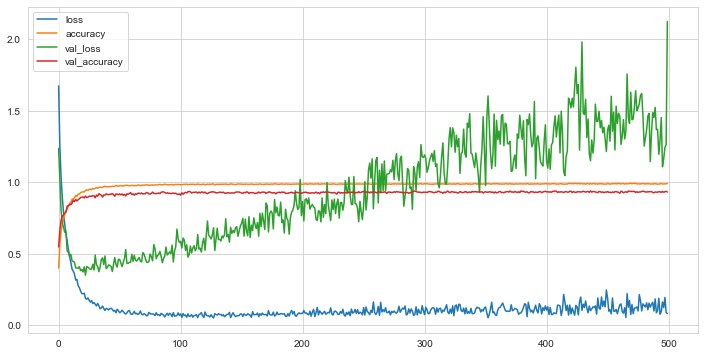

In [30]:
plotHistory(model_4_history)

# Model Evaluation

In [31]:
test_loss1, test_acc1  = model_1.evaluate(X_test, y_test, batch_size=128)
print('The test Loss is :',test_loss1)
print('\nThe test Accuracy is :',test_acc1)

8/8 [==============================] - 0s 2ms/step - loss: 0.5499 - accuracy: 0.8950
The test Loss is : 0.5498715043067932

The test Accuracy is : 0.8949950933456421


In [32]:
test_loss2, test_acc2  = model_2.evaluate(X_test, y_test, batch_size=128)
print('The test Loss is :',test_loss2)
print('\nThe test Accuracy is :',test_acc2)

8/8 [==============================] - 0s 3ms/step - loss: 0.3923 - accuracy: 0.9166
The test Loss is : 0.39228200912475586

The test Accuracy is : 0.9165849089622498


In [33]:
test_loss3, test_acc3  = model_3.evaluate(X_test, y_test, batch_size=128)
print('The test Loss is :',test_loss3)
print('\nThe test Accuracy is :',test_acc3)

8/8 [==============================] - 0s 3ms/step - loss: 0.3480 - accuracy: 0.9176
The test Loss is : 0.34802865982055664

The test Accuracy is : 0.9175662398338318


In [34]:
test_loss4, test_acc4  = model_4.evaluate(X_test, y_test, batch_size=128)
print('The test Loss is :',test_loss4)
print('\nThe test Accuracy is :',test_acc4)

8/8 [==============================] - 0s 7ms/step - loss: 1.6516 - accuracy: 0.9264
The test Loss is : 1.6516435146331787

The test Accuracy is : 0.9263984560966492


In [36]:
print('The 1st test Loss is :',test_loss1)
print('The 1st test Accuracy is :',test_acc1)
print('\nThe 2nd test Loss is :',test_loss2)
print('The 2nd test Accuracy is :',test_acc2)
print('\nThe 3rd test Loss is :',test_loss3)
print('The 3rd test Accuracy is :',test_acc3)
print('\nThe 4th test Loss is :',test_loss4)
print('The 4th test Accuracy is :',test_acc4)

The 1st test Loss is : 0.5498715043067932
The 1st test Accuracy is : 0.8949950933456421

The 2nd test Loss is : 0.39228200912475586
The 2nd test Accuracy is : 0.9165849089622498

The 3rd test Loss is : 0.34802865982055664
The 3rd test Accuracy is : 0.9175662398338318

The 4th test Loss is : 1.6516435146331787
The 4th test Accuracy is : 0.9263984560966492
